In [2]:
# import libraries
# Always run this cell first!
import numpy as np
import pandas as pd

import scipy
import statsmodels.api # appear to need to import the api as well as the library itself for the interpreter to find the modules
import statsmodels as sm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
import plotly.offline
plotly.offline.init_notebook_mode(connected=True) # make plotly work with Jupyter Notebook using CDN

# Hypothesis Testing for Categorical Data

## Statistical Decision Making: The Hypothesis Test

In the [last section](01_Foundations.ipynb), we saw how probabilty theory can help us to estimate how close a sample average is to the true average of a population using a confidence interval. 

In this section, we will look at another important tool in the statistician's repetoire, the statistical test of hypotheses. Hypothesis testing works much like the scientific method: we make a hypothesis about how the world works, construct an experiment to test it, gather data from the experiment, and then evaluate how closely that data fits the hypothesis.

Let's look at this process in the context of an example.

### The Wellcome Global Monitor Survey

The Wellcome Global Monitor survey, which is part of the World Gallup Poll, asks people around the world about their views on topics related to science and health. The [most recent data](https://doi.org/10.5255/UKDA-SN-8466-2), as of writing, is from 2018 and is available under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/). The data consists of survey answers from over 140,000 people in 144 different countries, collected in person or by telephone.

One of our goals in this chapter is to help you understand the statistical decision making process, and, through learning more, to have more confidence about how scientists move forward in their understanding. As a statistician and educator, I'm very interested in the level of trust people have in scientists and the scientific process. 

Hence, we are going to look today at the Wellcome Global Monitor's Trust in Scientists Index, which measures how much each respondent trusts scientists based on their answers to five of the questions in the survey:

- "How much do you trust scientists in your country?"
- "In general, how much do you trust scientists to find out accurate information about the world?"
- "How much do you trust scientists working in colleges/universities in this country to do their work with the intention of benefiting the public?"
- "How much do you trust scientists working in colleges/universities in this country to be open and honest about who is paying for their work?"
- "How much do you trust scientists working for companies in this country to do their work with the intention of benefiting the public?"

The answers are combined to rank each respondent's level of trust in scientists from "High Trust" to "Low Trust". Respondents that did not answer enough of the questions are recorded as "No Score".

The survey data we have is contained in a file named `wellcome_global_monitor_2018.csv`. This file contains a subset of the attributes from the original dataset, replacing numerical codes with their textual equivalents. The column labeled `Trust_Index` (originally named "WGM_Indexr") contains the Trust in Scientists Index.

In [3]:
wgm = pd.read_csv('wellcome_global_monitor_2018.csv')
wgm.sample(5).head() # display 5 randomly sampled rows

,Country,Q12,Q13,Age,AgeCategories,Gender,Education,Urban_Rural,Trust_Index_Numeric,Trust_Index,trustsScience_Q12,trustsScientists_Q13
90631,Bosnia and Herzegovina,Some,Some,30.0,30 to 49,Female,Secondary,Lives in city or suburb of city,2.800000,Medium trust,Yes,Yes
148552,Northern Cyprus,Some,Some,43.0,30 to 49,Female,Secondary,Lives in city or suburb of city,NaN,No score,Yes,Yes
113961,Kuwait,A lot,A lot,47.0,30 to 49,Male,Secondary,Lives in rural area or small town,3.333333,Medium trust,Yes,Yes
87299,Austria,Some,Some,45.0,30 to 49,Male,Tertiary,Lives in rural area or small town,3.200000,Medium trust,Yes,Yes
93959,Chile,A lot,A lot,80.0,50+,Male,Secondary,Lives in city or suburb of city,3.200000,Medium trust,Yes,Yes


Let's take a deeper look at the Trust in Scientists Index and see what levels of trust were recorded.

In [4]:
wgm["Trust_Index"].value_counts()

Trust_Index
Medium trust    77137
Low trust       28460
High trust      26161
No score        17256
Name: count, dtype: int64

In what follows, we are going to narrow our analysis to focus in on one country. In this case, we will look at the United States. If you're interested in a different country, later on you'll get a chance to repeat this analysis for a different country in the exercises. Or, if you're using the interactive notebook, you can change the code to use a different country!

In [5]:
wgm_usa = wgm[wgm['Country'] == "United States"]

Here's what the levels of trust for the sample from the United States look like:

In [6]:
wgm_usa["Trust_Index"].value_counts()

Trust_Index
Medium trust    563
High trust      282
Low trust       116
No score         45
Name: count, dtype: int64

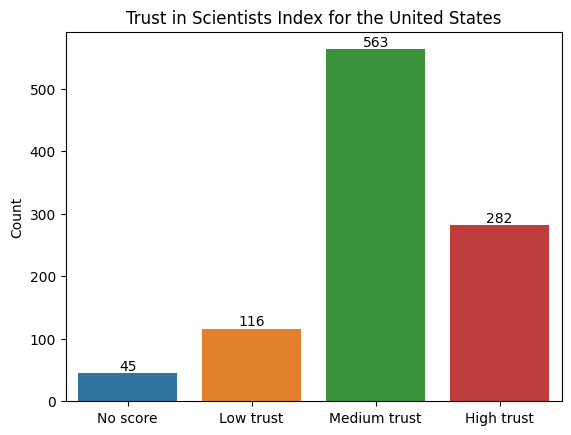

In [7]:
# create dataframe from counts of "Trust_Index" values
levels = wgm_usa["Trust_Index"].value_counts().reset_index(name="Count").rename(columns={"Trust_Index": "Trust_Level"})

# create bar plot
ax = sns.barplot(
    data = levels,
    x = "Trust_Level",
    y = "Count",
    order = ["No score", "Low trust", "Medium trust", "High trust"]
)

# label each bar with the corresponding value
for container in ax.containers:
    ax.bar_label(container)

# set axis labels and title
ax.set_xlabel("")
ax.set_title("Trust in Scientists Index for the United States");

### Making a Hypothesis

The first step in a hypothesis test is to determine the hypotheses that we are comparing. We are comparing two opposing views of the world: either it works like this, or it doesn't. These views are best understood in terms of *models*---a framework for understanding how the world works. 

For example, perhaps I think that the proportion of residents in the United States who have a high trust in scientists is large, say over 0.25. In this situation, the two models are statistical: we are hypothesizing about the proportion from a population. Either the proportion of people in our chosen country who have high trust in scientists is 0.25, or it's more than that. In mathematical terms, we'll write this as

\begin{equation}
    H_0: p = 0.25, \\
    H_1: p > 0.25.
\end{equation}

In other words, our null hypothesis, $H_0$, is that the proportion is 0.25. Our alternative hypothesis, $H_1$, is that the proportion is greater than 0.25. Remember that the null hypothesis should always be in the form "population parameter equals something".

We can make hypotheses about other parameters, such as mean or standard deviation, but we'll start here by working with proportions.

The statistical hypothesis test is the method for making a decision between these two models. We gather data and see how well the data fits with what we would expect based on the null hypothesis.

### How Much Evidence Do We Need?

After we have determined the hypotheses, the next step is to determine our threshold for making a decision. How much evidence do we need to reject our null hypothesis in favor of the alternative hypothesis? Another way to think about this is, how much risk are we willing to take to be wrong?

In this case, there are actaully *two* ways to make the wrong conclusion: we could reject our null hypothesis when it is actually true (called a **Type I error**), or we could fail to reject the null hypothesis when it is actually false (a **Type II error**). We won't go any deeper into Type II error at the moment, but it is just as important to consider!

The "risk level" or "evidence threshold" associated with the first type of wrong conclusion is denoted by the Greek letter $\alpha$ (alpha). For any given example, the value should be chosen based on both the context of the problem and the risk of making a Type I error that you are willing to take. Typical values for $\alpha$ in scientific literature are 0.1, 0.05, and 0.01, but these values are somewhat arbitrary. 

For instance, imagine you are trying to determine if a new medical treatment is more effective than a previous treatment. Suppose the new treatment has more potential for harmful side-effects than the previous treatment. In this case, you would want to be very sure the new treatment is better before you start using it widely, so you would want to set your $\alpha$-value to something smaller to make sure that the risk of making a Type I error is not too large.

In [8]:
alpha = 0.05

### The Test Statistic: Using Data to Decide

After determining the value of $\alpha$, the next step of a real-world study would be to gather the data we need and make a decision. In the statistics classroom, you typically have the data or summary statistics already available to you, as we do in this case.

We are asking questions about the proportion of people in the United States who have high trust in scientists. It would be impossible to get an answer from every single person in the entire country! However, the Wellcome Global Monitor data gives us answers from a large representative sample of people in the USA. So we can use this data to get a statistically sound idea of what the true proportion in the entire population is.

Let's compare the proportion from the sample to what the null hypothesis says it should be. If the sample proportion is close to what the null hypothesis says it should be, that would mean that the null hypothesis is probably right. On the other hand, if it is different, perhaps the null hypothesis is wrong!

We can compute the sample proportion of people with high trust in scientists by taking the total number of people in the sample with a high trust score and dividing it by the total sample size:

\begin{equation}
\hat p = \frac{\mbox{num. of respondents with high trust in scientists}}{\mbox{num. of respondents}}.
\end{equation}

In [9]:
# number of successes (i.e., people with high trust in scientists)
count = len(wgm_usa[wgm_usa["Trust_Index"] == "High trust"])

# sample size (i.e., the total number of observations)
nobs = len(wgm_usa["Trust_Index"])

# compute sample proportion
p_hat =  count / nobs
print(f"The sample proportion is {p_hat:.3f}. There are {nobs} total observations.")

The sample proportion is 0.280. There are 1006 total observations.


This is clearly more than $0.25$, the value in our null hypothesis! But remember that the sample proportion is variable, so it won't be *exactly* the same as the population proportion. So is this evidence for the alternative hypothesis?

We could ask a better question: is the sample proportion of 0.28 a lot different from our null hypothesis or just a little bit different? We can answer this using probability theory. Just like in the last section, the theoretical foundation for the hypothesis test is the Central Limit Theorem. Remember that if the sample size $n$ is large enough, sample proportions have a normal distribution, where the mean is the population proportion $p$, and the standard deviation is the population standard deviation $\sqrt{p(1-p)}$ divided by $\sqrt{n}$:

$$ \hat{p} \sim N\left(p, \sqrt{\frac{p(1-p)}{n}} \right). $$

Above we can see that $n = 1006$. If we assume the null hypothesis is true, then we also know what to fill in for $p$:

$$ \hat{p} \sim N\left(.25, \sqrt{\frac{.25(1-.25)}{1006}} \right). $$

We call this the **null distribution**, since it is the distribution of the sample statistic under the assumption that the null hypothesis is true.

Back to the question: is the difference between the observed value of $\hat p$ and the value that the null hypothesis says it should be a big difference or small difference? One way to answer that question would be to **standardize** by taking the difference between the sample mean and the (hypothesized) population mean and dividing by the standard deviation:

\begin{equation}
Z = \frac{\hat p - .25}{\sqrt{\frac{.25(1-.25)}{1006} }} \sim N(0,1)
\end{equation}

This gives us the standardized test statistic Z, which has a standard normal distribution ($\mu = 0, \sigma = 1$)---again assuming that the null hypothesis is true.

In [10]:
# standardize it
z_obs = ( p_hat - 0.25 ) / np.sqrt( 0.25*(1-0.25) / nobs )
print(f"The observed value of the test statistic Z is {z_obs:.3f}.")

The observed value of the test statistic Z is 2.221.


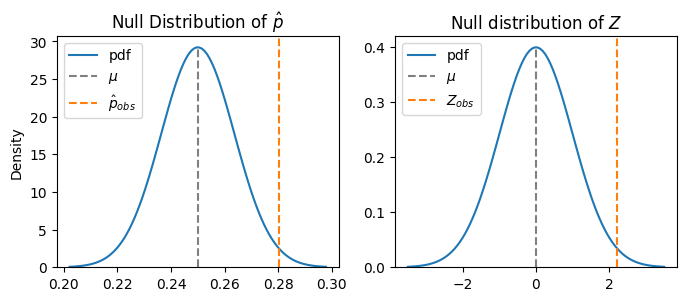

In [11]:
# dictionary with properties of each distribution
distributions = [
    {
        'name': 'Null Distribution of $\hat{p}$',
        'mean': 0.25, 'sd': np.sqrt(0.25*(1-0.25)/nobs),
        'stat': p_hat, 'stat_label': '$\hat{p}_{obs}$'
    },
    {
        'name': 'Null distribution of $Z$',
        'mean': 0, 'sd': 1,
        'stat': z_obs, 'stat_label': '$Z_{obs}$'
    }
]

# create plot
fig, axes = plt.subplots(1, len(distributions), figsize=(8,3))

# use default seaborn palette
palette = iter(sns.color_palette())
pdfcolor = next(palette)
statcolor = next(palette)

# for each distribution, plot the pdf, mean, and relevant statistic
for ax, distr in zip(axes, distributions):
    # plot pdf
    x = np.linspace(distr['mean'] - 3.5*distr['sd'], distr['mean'] + 3.5*distr['sd'], 100)
    ax.plot(x, scipy.stats.norm.pdf(x, distr['mean'], distr['sd']), color=pdfcolor, label='pdf')
    # plot mean
    ax.vlines(x=distr['mean'], ymin=0, ymax=scipy.stats.norm.pdf(distr['mean'], distr['mean'], distr['sd']), linestyle='dashed', color='grey', label='$\mu$')
    # plot statistic
    ax.axvline(distr['stat'], linestyle='dashed', color=statcolor, label=distr['stat_label'])
    # set y-axis limits to start at 0
    ax.set_ylim(0, ax.get_ylim()[1])
    # set title
    ax.set_title(distr['name'])
    # display legend
    ax.legend(loc='upper left')
    
axes[0].set_ylabel('Density');

This changes our difference to units of standard deviations. In other words, the sample proportion is 2.221 standard deviations above the mean value of 0. 

Think about it another way: if the null hypothesis is true, then most of the time $\hat p$ will be close to $p=0.25$, and hence $Z$ will be close to 0. But $\hat p$ varies, and hence $Z$ is variable. So how likely is it that $Z$ would be 2.221 standard deviations from what the null hypothesis says it should be most of the time? And how far away does it need to be before we would start to doubt the null hypothesis?

### Making a Decision

Now that we have a hypothesis and have calculated a test statistic to try to evaluate the hypothesis, we are ready to make a conclusion. Under the null hypothesis, we know the distribution of the sample statistic $\hat p$. However, we have just one observation of the sample proportion. 

So we ask, if the null hypothesis is true and the population proportion really is 0.25, how likely is it that we would observe the value of 0.28 or something even further away from 0.25? Or translated to $Z$-space, how likely is it to get a test statistic that is 2.221 or larger? 

We can use `scipy.stats` to compute directly compute this probability from a $N(0,1)$ distribution using the CDF function. We subtract the probability from 1 since the CDF always gives the probability to the *left* of a number, and we want the probability that $Z$ is *larger* or to the right of 2.221.

In [12]:
1 - scipy.stats.norm(0,1).cdf(z_obs)

0.013183855477092332

This value is called the $P$-value, and it measures the probability of observing a value at least as much greater than 0.25 as the value we actually observed is (assuming the null hypothesis is true). As the figure below shows, the $P$-value is the area under the probability density function of Z that is to the right of $Z_{obs}$. The smaller this area is, the less likely it is that, if the null hypothesis is indeed true and we took additional samples from our population, we would observe values of Z that are greater than or equal to $Z_{obs}$.

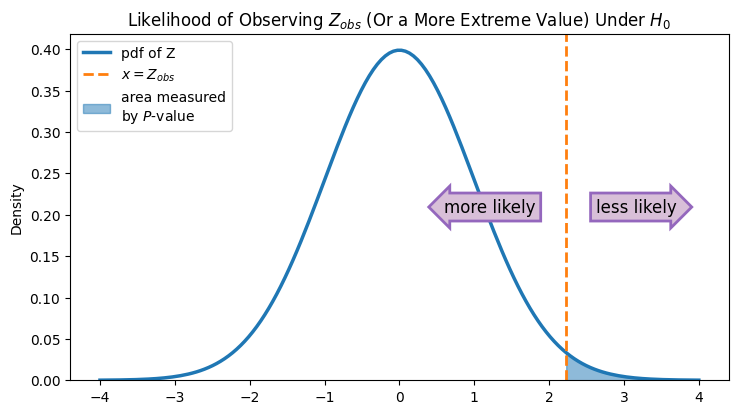

In [13]:
# graph illustrating the P-value

# create plot
fig, ax = plt.subplots(figsize=(8.5,4.5))

# use default seaborn palette
palette = sns.color_palette()
normcolor = palette[0]
zcolor = palette[1]
arrowcolor = palette[4]

# plot standard normal pdf (pdf of Z)
x = np.linspace(-4, 4, 150)
y = scipy.stats.norm.pdf(x, 0, 1)
ax.plot(x, y, color=normcolor, linewidth=2.5, label='pdf of Z')

# set lower y-axis limit to 0
ax.set_ylim(0, ax.get_ylim()[1])
half_ylim = sum(ax.get_ylim())/2 # coordinate at middle of y-axis

# plot and annotate Z_obs
ax.axvline(z_obs, linestyle='dashed', linewidth=2, color=zcolor, label='$x = Z_{obs}$')

# fill area under pdf represented by p-value
ax.fill_between(x, y, where = (x >= z_obs), color=normcolor, alpha=0.5, label='area measured\nby $P$-value')

# annotate directions of increasing and decreasing likelihood
ax.text(
    s = 'less likely',
    x = z_obs + 0.4,
    y = half_ylim,
    ha='left',
    va='center',
    size = 12,
    bbox = { 'boxstyle': 'rarrow', 'facecolor': 'thistle', 'edgecolor': arrowcolor, 'linewidth': 2 }
)
ax.text(
    s = 'more likely',
    x = z_obs - 0.4,
    y = half_ylim,
    ha='right',
    va='center',
    size = 12,
    bbox = { 'boxstyle': 'larrow', 'facecolor': 'thistle', 'edgecolor': arrowcolor, 'linewidth': 2 }
)

# set up legend, y-axis label, and title
ax.legend(loc='upper left')
ax.set_ylabel('Density')
ax.set_title('Likelihood of Observing $Z_{obs}$ (Or a More Extreme Value) Under $H_{0}$');

In some sense, the $P$-value quantifies the evidence you have *against* the null hypothesis. If the $P$-value is small, then that means that if the null hypothesis is really true, then it is unlikely that you would get the value of $\hat p$ that you did. In other words, a small $P$-value indicates that the data is in disagreement with the statistical model given by the null hypothesis.

Based on the $P$-value, we can make our decision. A $P$-value is small enough if it is below the threshold of $\alpha$ that we set previously. If the $P$-value is less than $\alpha$, then our test statistic is incompatible with the null hypothesis, and we will **reject the null hypothesis**. But if the $P$-value is greater than or equal to $\alpha$, then our data is compatible with the null hypothesis, and we will **fail to reject the null hypothesis**. 

In this case, we have chosen $\alpha = 0.05$, and our $P$-value is 0.013. Since $0.013 < 0.05$, we will reject the null hypothesis.


**Note:** Make sure you understand the difference between the population proportion $p$ and the $P$-value---they are very different! We chose to capitalize the $P$ in $P$-value to make this distinction more clear, but this is not the way you will find it in every book.

In Python, we can put this all together using the `statsmodels` library, which we imported at the top of the notebook and gave the alias `sm`.

A test for proportions using `statsmodels` is performed below by calling `sm.stats.proportion.proportions_ztest(...)`. The name `proportions_ztest` indicates that we will be using the standard normal distribution to model the test statistic. 

The arguments required by the test are all of the things we calculated above: the number of people with high trust in scientists (`count`), the sample size (`nobs`), and the hypothesized value of the proportion (`p0`). Because the alternative hypothesis is that $p > 0.25$, we add `alternative = "larger"`. Other possibilities for the alternative hypothesis are `"smaller"` or `"two-sided"`. The code returns the test statistic and the $P$-value associated with the hypothesis test.

In [14]:
p0 = 0.25 # proportion under null hypothesis
(stat, pval) = sm.stats.proportion.proportions_ztest(
    count = len(wgm_usa[wgm_usa["Trust_Index"] == "High trust"]), # number of successes
    nobs = len(wgm_usa["Trust_Index"]), # number of observations
    value = p0,
    alternative = "larger",
    prop_var = p0, # use proportion under null hypothesis to calculate variance for test statistic
)
print(f"Z-test for proportion: test statistic is {stat:.3f}, P-value is {pval:.3f}.")

Z-test for proportion: test statistic is 2.221, P-value is 0.013.


As you can see, `statsmodels` gives us the same test statistic and $P$-value that we found earlier. As before, since $0.013 < 0.05$, we reject the null hypothesis. Note that the output of the code doesn't tell you what conclusion to make. Remember again that $\alpha$, the threshold for making your conclusion, is context-dependent, and the $P$-value is just one part of making a decision.

## Difference of Two Proportions

We can also use hypothesis testing to compare two proportions. This test is most common when you want to see if a population proportion is the same in two independent populations. For example, maybe we want to see if the proportion of men in the United States who have high trust in scientists ($p_1$) is different than the proportion of women in the United States who have high trust in scientists ($p_2$). Our two hypotheses are

\begin{equation}
    H_0: p_1 - p_2 = 0, \\
    H_1: p_1 - p_2 \neq 0.
\end{equation}

The main difference between this set of hypotheses and the previous set of hypotheses is that we aren't making a claim about whether the difference is bigger or smaller than a given value, just that it is different from that value. This will come into play later on when we quantify our evidence using the $P$-value.

Just as before, we will use the sample proportions of men and women from our survey to make a determination between the two hypotheses. Let's take a look at these:

In [15]:
# divide into two data sets
wgm_m = wgm_usa[wgm_usa['Gender'] == "Male"]
wgm_f = wgm_usa[wgm_usa['Gender'] == "Female"]

# number of successes (i.e., people with high trust in scientists)
count_m = len(wgm_m[wgm_m["Trust_Index"] == "High trust"])
count_f = len(wgm_f[wgm_f["Trust_Index"] == "High trust"])

# sample size (i.e., the total number of observations)
nobs_m = len(wgm_m["Trust_Index"])
nobs_f = len(wgm_f["Trust_Index"])

# compute sample proportion
p_hat_m =  count_m / nobs_m
p_hat_f = count_f / nobs_f
print(f"The sample proportion for men is {p_hat_m:.3f}. There are {nobs_m} total observations for men.")
print(f"The sample proportion for women is {p_hat_f:.3f}. There are {nobs_f} total observations for women.")

The sample proportion for men is 0.262. There are 542 total observations for men.
The sample proportion for women is 0.302. There are 464 total observations for women.


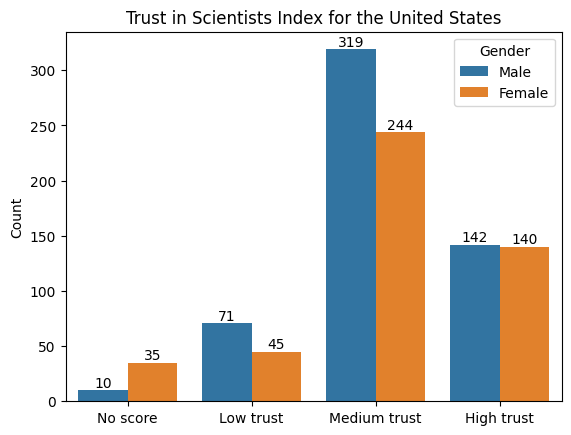

In [16]:
# get dataframe
levels = wgm_usa[["Gender", "Trust_Index"]].value_counts().reset_index(name="Count").rename(columns={"Trust_Index": "Trust_Level"})

# create bar plot
ax = sns.barplot(
    data = levels,
    x = "Trust_Level",
    y = "Count",
    hue = "Gender",
    order = ["No score", "Low trust", "Medium trust", "High trust"]
)
for container in ax.containers:
    ax.bar_label(container)
ax.set_xlabel("")
ax.set_title("Trust in Scientists Index for the United States");

Overall, in our sample we see a difference of about 0.04 between the proportions of men and women who have high trust in scientists. Again we ask, is that a large difference?

Recall that if our sample sizes $n_1$ and $n_2$ are large enough,

\begin{equation}
    \hat p_1 - \hat p_2 \sim N\left(p_1 - p_2, \sqrt{ \frac{p_1(1-p_1)}{n_1} + \frac{p_2(1-p_2)}{n_2}  } \right).
\end{equation}

and hence

\begin{equation}
    Z = \frac{\hat p_1 - \hat p_2 - (p_1 - p_2)}{ \sqrt{ \frac{p_1(1-p_1)}{n_1} + \frac{p_2(1-p_2)}{n_2}  } } \sim N(0,1).
\end{equation}

The null hypothesis tells us what to fill in for $p_1-p_2$, but it doesn't hypothesize directly about the values of $p_1$ or $p_2$. However, it does hypothesize that $p_1 = p_2$, and it that is true, then our estimates $\hat p_1$ and $\hat p_2$ are estimating the same thing. In that case, we can combine them to estimate the variance. Define $p$ to be the common value of $p_1 = p_2 = p$. Then the variance of our test statistic is

\begin{equation}
\sqrt{ \frac{p_1(1-p_1)}{n_1} + \frac{p_2(1-p_2)}{n_2}  }  = \sqrt{ \frac{p(1-p)}{n_1} + \frac{p(1-p)}{n_2}  } = \sqrt{ p(1-p)\left( \frac{1}{n_1} + \frac{1}{n_2}\right)  },
\end{equation}

and we can estimate $p$ using

\begin{equation}
    p \approx \hat p = \frac{\mbox{num. of male respondents with high trust in scientists} + \mbox{num. of female respondents with high trust in scientists}}{\mbox{num. of male respondents} + \mbox{num. of female respondents}}.
\end{equation}

We call $\hat p$ the **pooled sample proportion**. 

In [17]:
p_hat = (count_m + count_f) / (nobs_m + nobs_f)
print(f"The pooled sample proportion is {p_hat:.3f}.")

The pooled sample proportion is 0.280.


Now, using the formula for $Z$ above, we can calculate the test statistic.

In [18]:
z_obs = (p_hat_m - p_hat_f) / np.sqrt( p_hat*(1-p_hat)*(1/nobs_m + 1/nobs_f))
print(f"The observed value of the test statistic Z is {z_obs:.3f}.")

The observed value of the test statistic Z is -1.399.


Now that we have the test statistic, we can quantify the evidence that we have in relation to our two hypotheses. Since the alternative hypothesis is just interested in finding differences from 0, then values of $Z$ that are a lot above 0 *or* a lot below 0 would be evidence against the null hypothesis.

In other words, if $p_1 - p_2$ really is 0, then $Z$ will be close to 0 most of the time. If it's not, then it is more likely that $Z$ is far from 0. We can quantify this through the $P$-value, which again is calculating the probability that we would observe a value a least as far from 0 as the one that we did. We double the value from the CDF here to get the $P$-value since "far away" includes both the positive and negative directions.

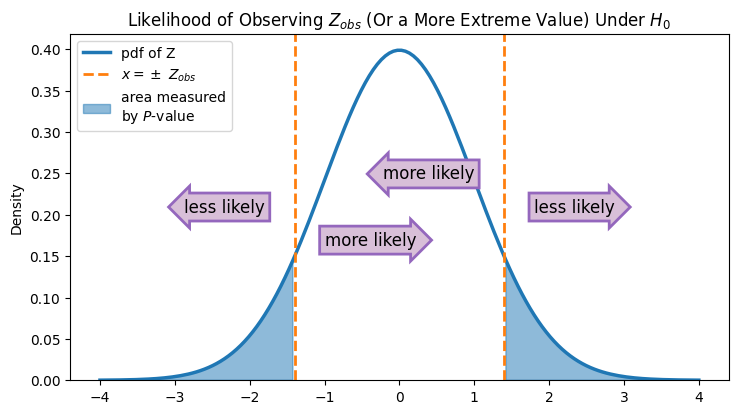

In [19]:
abs_z_obs = abs(z_obs)

# create plot
fig, ax = plt.subplots(figsize=(8.5,4.5))

# use default seaborn palette
palette = sns.color_palette()
normcolor = palette[0]
zcolor = palette[1]
arrowcolor = palette[4]

# plot standard normal pdf (pdf of Z)
x = np.linspace(-4, 4, 150)
y = scipy.stats.norm.pdf(x, 0, 1)
ax.plot(x, y, color=normcolor, linewidth=2.5, label='pdf of Z')

# set lower y-axis limit to 0
ax.set_ylim(0, ax.get_ylim()[1])
half_ylim = sum(ax.get_ylim())/2 # coordinate at middle of y-axis

# plot and annotate Z_obs and -Z_obs
ax.axvline(z_obs, linestyle='dashed', linewidth=2, color=zcolor, label='$x = \pm$ $Z_{obs}$')
ax.axvline(-z_obs, linestyle='dashed', linewidth=2, color=zcolor)

# fill area under pdf represented by p-value
ax.fill_between(x, y, where = (x < -abs_z_obs) | (x > abs_z_obs), color=normcolor, alpha=0.5, label='area measured\nby $P$-value')

# annotate directions of increasing and decreasing likelihood
ax.text(
    s = 'less likely',
    x = abs_z_obs + 0.4,
    y = half_ylim,
    ha='left',
    va='center',
    size = 12,
    bbox = { 'boxstyle': 'rarrow', 'facecolor': 'thistle', 'edgecolor': arrowcolor, 'linewidth': 2 }
)
ax.text(
    s = 'more likely',
    x = abs_z_obs - 0.4,
    y = half_ylim + 0.04,
    ha='right',
    va='center',
    size = 12,
    bbox = { 'boxstyle': 'larrow', 'facecolor': 'thistle', 'edgecolor': arrowcolor, 'linewidth': 2 }
)
ax.text(
    s = 'more likely',
    x = -abs_z_obs + 0.4,
    y = half_ylim - 0.04,
    ha='left',
    va='center',
    size = 12,
    bbox = { 'boxstyle': 'rarrow', 'facecolor': 'thistle', 'edgecolor': arrowcolor, 'linewidth': 2 }
)
ax.text(
    s = 'less likely',
    x = -abs_z_obs - 0.4,
    y = half_ylim,
    ha='right',
    va='center',
    size = 12,
    bbox = { 'boxstyle': 'larrow', 'facecolor': 'thistle', 'edgecolor': arrowcolor, 'linewidth': 2 }
)

# set up legend, y-axis label, and title
ax.legend(loc='upper left')
ax.set_ylabel('Density')
ax.set_title('Likelihood of Observing $Z_{obs}$ (Or a More Extreme Value) Under $H_{0}$');

Let's see what this $P$-value is:

In [20]:
2*(scipy.stats.norm(0,1).cdf(z_obs))

0.1619277283048255

This $P$-value is fairly large ($>0.05$), indicating that if the null hypothesis is true, it's not unlikely that we would observe a difference of 4% in our sample. So we fail to reject the null hypothesis because we do not find evidence in our data of a difference of high trust in scientists between men and women in the United States. 

## Using Python for the test

Of course, we're here to see how to perform these tests using Python code! The function to perform the test is the same as the one from the previous section, except this time the arguments `count` and `nobs` each take a list containing the relevant information from both of our samples. We have changed the value of the argument `alternative` to account for the fact that we are performing a `two-sided` test.

In [21]:
p0 = 0 # proportion under null hypothesis
(stat, pval) = sm.stats.proportion.proportions_ztest(
    count = [
        count_m, # number of successes for sample 1
        count_f, # number of successes for sample 2
    ],
    nobs = [
        nobs_m, # number of observations for sample 1
        nobs_f, # number of observations for sample 2
    ],
    value = p0,
    alternative = "two-sided",
    prop_var = False, # use pooled sample proportion to calculate variance for test statistic
)
print(f"Z-test for difference of two proportions: test statistic is {stat:.3f}, P-value is {pval:.3f}.")

Z-test for difference of two proportions: test statistic is -1.399, P-value is 0.162.


Again, these values match up with what we did before, so the conclusion is the same!

## Exercises

### Exercise 1

To get some practice, we are going to look at trust in scientists in a different country.

1. Pick another country (perhaps your country of origin or another country you are interested in) and filter the observations to just include responses from that country. For example, here is how to do that for the United States.

In [22]:
wgm_usa = wgm[wgm['Country'] == "United States"]

2. Make a hypothesis about the proportion of all the people in your chosen country that have `High trust` in scientists. For example, do you think it is over 20%? Under 15%? Make any hypothesis you like.

3. Choose a level of $\alpha$.

4. Compute the value of $\hat p$.

5. Run a hypothesis test using `statsmodels`.

6. Write your conclusion in a complete sentence. Be sure to report the test statistic and the $P$-value. If you found a significant result, give a confidence interval for the proportion.

### Exercise 2

1. Pick a second country of interest.

2. Write hypotheses to test whether the proportion of people in the first country with high trust in scientists is higher than the same proportion in the second country.

3. Choose a level of $\alpha$.

4. Run the hypothesis test using `statsmodels`.

5. Write your conclusion in a complete sentence. Be sure to report the test statistic and the $P$-value. If you found a significant difference, give a confidence interval for the difference in proportions.